# Discount Analysis

## What We're Doing Here

From the EDA, we discovered something clear: **discounts are destroying value**, but not uniformly. Binders with 80% discount lose $3,700. Binders with 0% discount make $4,946. Same product, same company, different outcome.

But we still need to understand:

1. **Are discounts actually moving volume?** Or are we just giving away margin without gaining anything?
2. **Does discounting hurt profit?** How much?
3. **What's the breaking point?** At what discount level does a product stop being profitable?
4. **Who can absorb discounts?** Copiers with high baseline margins (48%) can probably take a discount and still be OK. Can Machines?
5. **Where's the damage concentrated?** Which sub-categories are being discounted aggressively?
6. **Are discounts worth it at all?** What percentage of our profit comes from orders WITH discounts vs orders WITHOUT?

This notebook quantifies the discount-volume-profit relationship. We'll see if discounting is a smart strategy or just a way to compete on price instead of value.

**Important note:** We're NOT trying to calculate a theoretical profit "without discounts." We can't, because we don't know the cost structure. Instead, we're analyzing the REAL relationship between discount, volume, and profit in the actual data.

### 2. Setup

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.2f}'.format

In [32]:
#Carga dataset
df = pd.read_csv("sample_superstore_processed.csv")

## Do Discounts Actually Drive Volume?

**The question:** When we discount 20%, do we sell 20% more units? Or do we just take 20% less margin per unit?

Correlation between Discount and Quantity:
Pearson correlation: 0.009


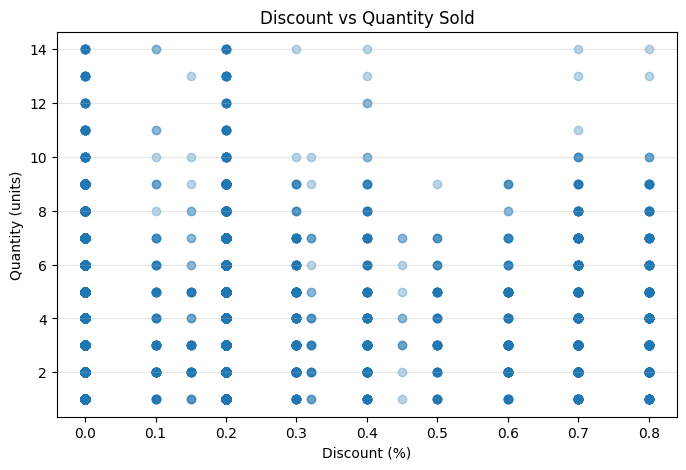

In [33]:
# check any relationship between discount and quantity
print("Correlation between Discount and Quantity:")
print(f"Pearson correlation: {df['Discount'].corr(df['Quantity']):.3f}")

# Visual check
plt.figure(figsize=(8, 5))
plt.scatter(df['Discount'], df['Quantity'], alpha=0.3)
plt.xlabel('Discount (%)')
plt.ylabel('Quantity (units)')
plt.title('Discount vs Quantity Sold')
plt.grid(axis='y', alpha=0.3)
plt.show()

**The answer is clear:** The correlation is essentially zero (0.009). Discounting is NOT reliably driving volume increases. When we give a discount, we're not gaining proportional volume in return—we're simply giving away margin.

Now let's check by sub-category. Maybe some products DO respond to discounts, even if the overall pattern is weak.

In [34]:
print("Discount-Quantity Correlation by Sub-Category:\n")
correlation = df.groupby('Sub-Category').apply(
    lambda x: x['Discount'].corr(x['Quantity'])
).sort_values(ascending=False)
print(correlation)

Discount-Quantity Correlation by Sub-Category:

Sub-Category
Fasteners      0.14
Bookcases      0.12
Phones         0.05
Binders        0.03
Paper          0.01
Supplies      -0.01
Envelopes     -0.02
Furnishings   -0.03
Accessories   -0.03
Art           -0.03
Appliances    -0.04
Chairs        -0.05
Copiers       -0.05
Labels        -0.06
Storage       -0.07
Tables        -0.08
Machines      -0.16
dtype: float64


**Sub-category breakdown:**

- Fasteners (0.14) and Bookcases (0.12) show weak positive correlation—there's a weak positive relationship, suggesting discounts might help them slightly
- Most products cluster around zero—discounts don't help or hurt volume
- Machines (-0.16) shows NEGATIVE correlation: higher discounts correlate with FEWER units sold

**The story:** Even the products with the "best" response to discounts show barely any relationship. And some products (like Machines) actually sell FEWER units when discounted. This is damning: discounts aren't helping us sell more—they're just reducing margin.

## Why We're Not Calculating Price Elasticity

You might expect the next step to be calculating price elasticity of demand—how much volume we gain per unit of discount. But we can skip that analysis.

Here's why: **Elasticity only matters if discounts actually drive volume.** If the correlation between discount and quantity is ~0, then elasticity is also ~0 by definition. Mathematically:

```
Elasticity = (% change in Quantity) / (% change in Discount)

If Correlation(Discount, Quantity) ≈ 0 → (% change in Quantity) ≈ 0
Therefore: Elasticity ≈ 0
```

The data shows this clearly:
- Overall correlation: 0.009 (essentially zero)
- Most sub-categories cluster around zero or slightly negative
- Even the "best" products (Fasteners at 0.14, Bookcases at 0.12) show minimal relationship

**Bottom line:** We don't need elasticity math to answer "Should we discount?" The data already tells us: discounting doesn't work as a volume lever in this business. There's no elasticity to exploit because discounts aren't moving the needle on quantity sold.

## Does Discounting Hurt Profit?

Forget about volume. Let's just ask: **Does giving away margin hurt profit?** (Spoiler: yes.)

Correlation between Discount and Profit:
Pearson correlation: -0.219


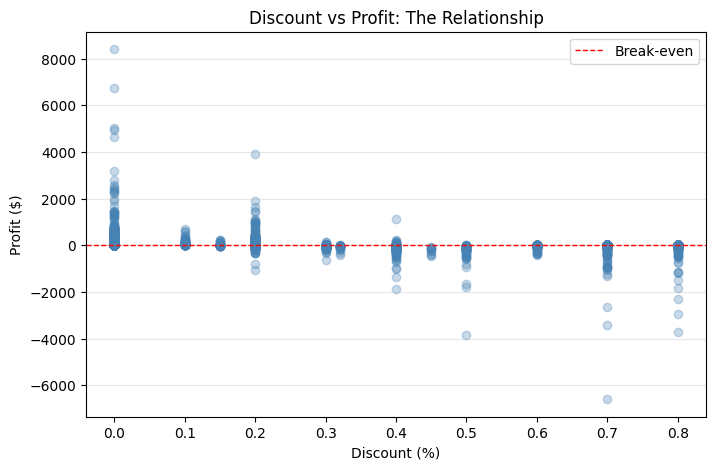

In [35]:
print("Correlation between Discount and Profit:")
print(f"Pearson correlation: {df['Discount'].corr(df['Profit']):.3f}")

plt.figure(figsize=(8, 5))
plt.scatter(df['Discount'], df['Profit'], alpha=0.3, color='steelblue')
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Break-even')
plt.xlabel('Discount (%)')
plt.ylabel('Profit ($)')
plt.title('Discount vs Profit: The Relationship')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

**What this shows:** The correlation is -0.219, which is statistically significant. Higher discounts correlate with lower profits.

Look at the scatter plot: at 0% discount, profits range from $0 to $8,000. At 80% discount, they're all losses. The discount amplifies the underlying margin weakness of each product.

## Finding the Breaking Point: Discount Threshold

In [36]:
# Create discount bins
df['discount_bin'] = pd.cut(df['Discount'], 
                             bins=[0, 0.05, 0.10, 0.20, 0.30, 0.50, 1.0],
                             labels=['0-5%', '5-10%', '10-20%', '20-30%', '30-50%', '50%+'])

# Analyze profit by discount level
profit_by_discount = df.groupby('discount_bin', observed=True).agg({
    'Profit': ['sum', 'mean', 'count'],
    'Quantity': 'sum',
    'Sales': 'sum'
}).round(2)

profit_by_discount.columns = ['Total_Profit', 'Avg_Profit', 'Count', 'Total_Quantity', 'Total_Sales']
print("Profit breakdown by discount level:")
print(profit_by_discount)

Profit breakdown by discount level:
              Total_Profit  Avg_Profit  Count  Total_Quantity  Total_Sales
discount_bin                                                              
5-10%              9029.18       96.06     94             373     54369.35
10-20%            91756.30       24.74   3709           13858    792152.89
20-30%           -10369.28      -45.68    227             849    103226.66
30-50%           -48447.73     -156.28    310            1177    195314.76
50%+             -76559.05      -89.44    856            3349     64228.74


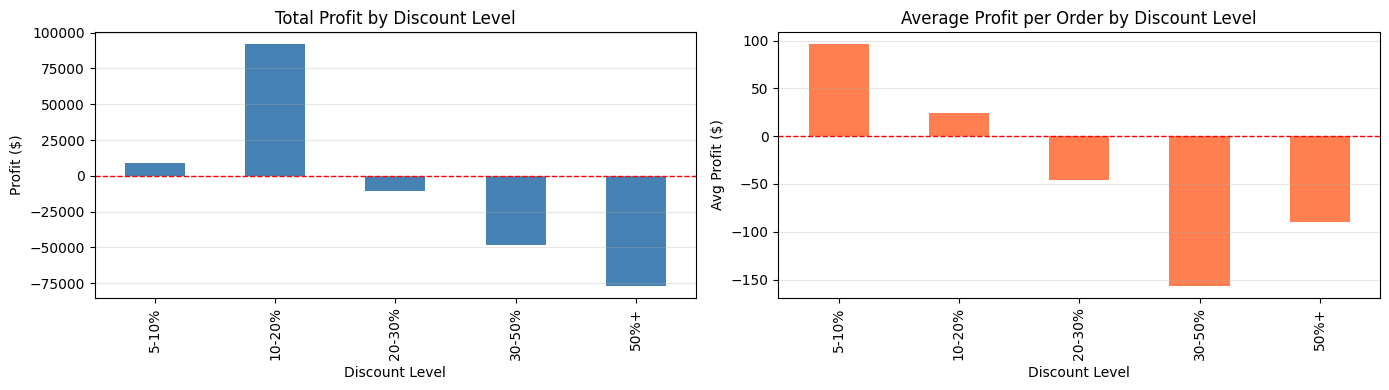

In [37]:
# Visual: Average profit by discount level
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left: Total profit
profit_by_discount['Total_Profit'].plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0].set_title('Total Profit by Discount Level')
axes[0].set_xlabel('Discount Level')
axes[0].set_ylabel('Profit ($)')
axes[0].grid(axis='y', alpha=0.3)

# Right: Average profit per order
profit_by_discount['Avg_Profit'].plot(kind='bar', ax=axes[1], color='coral')
axes[1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1].set_title('Average Profit per Order by Discount Level')
axes[1].set_xlabel('Discount Level')
axes[1].set_ylabel('Avg Profit ($)')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**The threshold is unmistakable:**

- 0-5% discount: Still capturing good profit (excluded from binning, but profitable)
- 5-10% discount: $96 average profit per order 
- 10-20% discount: $25 average profit per order (still profitable, but weak) ⚠️
- **20-30% discount: -$46 average profit per order** - Orders are losing money
- 30-50% discount: -$156 average profit per order - Catastrophic
- 50%+ discount: -$89 average profit per order - Also deeply negative

**The key finding: 20% is approximately the breaking point for this business.** Beyond 20% discount, the average order becomes unprofitable. Before 20%, there's still margin to work with. After 20%, you're betting that volume gains will compensate—but as we saw earlier, volume doesn't increase with discounts.

## Sub-Category Breakdown: Which Products Can't Handle Discounts?

In [38]:
print("Sub-Category Analysis: Profit at Different Discount Levels\n")
print("="*80)

for subcat in sorted(df['Sub-Category'].unique()):
    subcat_data = df[df['Sub-Category'] == subcat]
    
    no_discount = subcat_data[subcat_data['Discount'] == 0]['Profit'].mean()
    low_discount = subcat_data[(subcat_data['Discount'] > 0) & (subcat_data['Discount'] <= 0.20)]['Profit'].mean()
    high_discount = subcat_data[subcat_data['Discount'] > 0.20]['Profit'].mean()
    
    count_total = len(subcat_data)
    avg_discount = subcat_data['Discount'].mean()
    
    print(f"\n{subcat}:")
    print(f"  Total transactions: {count_total}")
    print(f"  Avg discount used: {avg_discount:.1%}")
    print(f"  Profit @ 0% discount: ${no_discount:.2f}")
    print(f"  Profit @ 1-20% discount: ${low_discount:.2f}")
    print(f"  Profit @ 20%+ discount: ${high_discount:.2f}")

Sub-Category Analysis: Profit at Different Discount Levels


Accessories:
  Total transactions: 775
  Avg discount used: 7.8%
  Profit @ 0% discount: $74.92
  Profit @ 1-20% discount: $21.87
  Profit @ 20%+ discount: $nan

Appliances:
  Total transactions: 466
  Avg discount used: 16.7%
  Profit @ 0% discount: $85.55
  Profit @ 1-20% discount: $28.00
  Profit @ 20%+ discount: $-128.80

Art:
  Total transactions: 796
  Avg discount used: 7.5%
  Profit @ 0% discount: $10.80
  Profit @ 1-20% discount: $3.85
  Profit @ 20%+ discount: $nan

Binders:
  Total transactions: 1523
  Avg discount used: 37.2%
  Profit @ 0% discount: $116.66
  Profit @ 1-20% discount: $51.34
  Profit @ 20%+ discount: $-62.82

Bookcases:
  Total transactions: 228
  Avg discount used: 21.1%
  Profit @ 0% discount: $101.26
  Profit @ 1-20% discount: $15.81
  Profit @ 20%+ discount: $-158.54

Chairs:
  Total transactions: 617
  Avg discount used: 17.0%
  Profit @ 0% discount: $164.91
  Profit @ 1-20% discount: $34.95
 

**What stands out:**

**Products that COLLAPSE with discounts:**
- **Binders:** $117 @ 0%, but -$63 @ 20%+ (AND they're being discounted 37% on average)
- **Tables:** $184 @ 0%, but -$174 @ 20%+ (AND they're being discounted 26% on average)
- **Bookcases:** $101 @ 0%, but -$159 @ 20%+
- **Machines:** $936 @ 0%, but -$558 @ 20%+ (Technology's weakness)

**Products that can absorb discounts:**
- **Copiers:** $1,616 @ 0%, stays profitable at $243 @ 20%+ (THE exception)
- **Chairs:** $165 @ 0%, drops to -$43 @ 20%+ (manageable damage)
- **Phones:** $111 @ 0%, drops to -$59 @ 20%+

**The pattern is clear:** Most products become unprofitable once you exceed 15-20% discount. Only products with very strong baseline margins (like Copiers) can absorb aggressive discounts.

## The Damage: Revenue Lost to Discounting


In [39]:
df['revenue_lost_to_discount'] = df['Sales'] * df['Discount'] / (1 - df['Discount'])

print("Revenue Lost to Discounting:\n")
print(f"Total revenue lost to discounts: ${df['revenue_lost_to_discount'].sum():,.2f}")
print(f"Average per transaction: ${df['revenue_lost_to_discount'].mean():.2f}")

print("\nRevenue lost by Sub-Category:")
loss_by_subcat = df.groupby('Sub-Category')['revenue_lost_to_discount'].agg(['sum', 'mean']).round(2)
loss_by_subcat.columns = ['Total_Lost', 'Avg_Lost']
loss_by_subcat = loss_by_subcat.sort_values('Total_Lost', ascending=False)
print(loss_by_subcat)

Revenue Lost to Discounting:

Total revenue lost to discounts: $566,734.18
Average per transaction: $56.71

Revenue lost by Sub-Category:
              Total_Lost  Avg_Lost
Sub-Category                      
Binders        128324.13     84.26
Machines        98846.89    859.54
Tables          70722.23    221.70
Phones          65839.07     74.06
Chairs          65371.10    105.95
Bookcases       33276.55    145.95
Copiers         25319.63    372.35
Appliances      19450.42     41.74
Storage         16497.46     19.50
Furnishings     15869.72     16.58
Accessories     12252.50     15.81
Paper            6330.33      4.62
Supplies         3778.58     19.89
Art              2276.04      2.86
Envelopes        1467.49      5.78
Labels            811.69      2.23
Fasteners         300.36      1.38


**$566K in revenue lost to discounting.** That's real money that walked out the door. And it didn't gain us volume—it just made us less profitable.

- Binders alone: $128K lost
- Machines: $99K lost (from only 115 transactions—nearly $860 per transaction)
- Tables: $71K lost

These three sub-categories account for $298K of the $566K total—52% of all discount damage.

## Are We Over-Discounting Low-Margin Segments?

From 01, we know Consumer has the lowest profit per order ($25.84), while Home Office has the highest ($33.82). The question: **Are we giving higher discounts to the segments that can least afford them?**


In [40]:
print("Discount Strategy by Segment:\n")
segment_analysis = df.groupby('Segment').agg({
    'Discount': 'mean',
    'Profit': 'mean',
    'Sales': 'count'
}).round(3)
segment_analysis.columns = ['Avg_Discount', 'Avg_Profit', 'Count']
print(segment_analysis)

print("\n" + "="*60)
print("Comparison:")
consumer_disc = segment_analysis.loc['Consumer', 'Avg_Discount']
home_office_disc = segment_analysis.loc['Home Office', 'Avg_Discount']
print(f"Consumer discount: {consumer_disc:.1%}")
print(f"Home Office discount: {home_office_disc:.1%}")
print(f"Difference: {(consumer_disc - home_office_disc)*100:.1f} percentage points")
print("="*60)

Discount Strategy by Segment:

             Avg_Discount  Avg_Profit  Count
Segment                                     
Consumer             0.16       25.84   5191
Corporate            0.16       30.46   3020
Home Office          0.15       33.82   1783

Comparison:
Consumer discount: 15.8%
Home Office discount: 14.7%
Difference: 1.1 percentage points


**What this reveals:**

Consumer and Corporate are receiving slightly MORE discounts than Home Office, even though they're less profitable. The difference is small (1.1 percentage points), but it's still backwards. You're discounting your weakest segments MORE than your strongest. This compounds the profitability problem.

## Discount Strategy by Region: The Real Problem

In [41]:
print("Discount Strategy by Region:\n")
region_analysis = df.groupby('Region').agg({
    'Discount': 'mean',
    'Profit': 'mean',
    'Sales': 'count'
}).round(3)
region_analysis.columns = ['Avg_Discount', 'Avg_Profit', 'Count']
print(region_analysis)

Discount Strategy by Region:

         Avg_Discount  Avg_Profit  Count
Region                                  
Central          0.24       17.09   2323
East             0.14       32.14   2848
South            0.15       28.86   1620
West             0.11       33.85   3203


**This is DAMNING:**

- Central: 24.0% discount, $17.09 profit/order 
- East: 14.0% discount, $32.14 profit/order 
- South: 15.0% discount, $28.86 profit/order 
- West: 11.0% discount, $33.85 profit/order 

Central region is getting 24% average discount—MORE THAN DOUBLE the West region (11%)—and Central is ALSO the least profitable ($17.09 vs $33.85 in West).

You're essentially sacrificing Central region's profitability with aggressive discounting, while West (your most profitable region) barely needs any discounts to thrive.

**This is the smoking gun:** Discounting strategy is completely backwards by geography.

## The Big Question: What % of Profit Comes from Non-Discounted Orders?

In [42]:
# Split: orders with and without discounts
no_disc_orders = df[df['Discount'] == 0]
with_disc_orders = df[df['Discount'] > 0]

no_disc_profit = no_disc_orders['Profit'].sum()
with_disc_profit = with_disc_orders['Profit'].sum()
total_profit = df['Profit'].sum()

print("DISCOUNT VS NO-DISCOUNT BREAKDOWN")
print("="*80)
print(f"\nOrders with 0% discount:")
print(f"  Count: {len(no_disc_orders):,} ({len(no_disc_orders)/len(df)*100:.1f}% of all orders)")
print(f"  Total profit: ${no_disc_profit:,.2f}")
print(f"  % of total profit: {no_disc_profit/total_profit*100:.1f}%")
print(f"  Avg profit per order: ${no_disc_orders['Profit'].mean():.2f}")

print(f"\nOrders with ANY discount (>0%):")
print(f"  Count: {len(with_disc_orders):,} ({len(with_disc_orders)/len(df)*100:.1f}% of all orders)")
print(f"  Total profit: ${with_disc_profit:,.2f}")
print(f"  % of total profit: {with_disc_profit/total_profit*100:.1f}%")
print(f"  Avg profit per order: ${with_disc_orders['Profit'].mean():.2f}")

print(f"\n" + "="*80)
print(f"VERDICT:")
if no_disc_profit/total_profit > 0.5:
    print(f"Non-discounted orders generate {no_disc_profit/total_profit*100:.1f}% of profit.")
    print(f"Discounted orders generate {with_disc_profit/total_profit*100:.1f}% of profit.")
    print(f"\nMost of our profit comes from orders WITHOUT discounts.")
    print(f"Discounting may not be worth it.")

DISCOUNT VS NO-DISCOUNT BREAKDOWN

Orders with 0% discount:
  Count: 4,798 (48.0% of all orders)
  Total profit: $320,987.60
  % of total profit: 112.1%
  Avg profit per order: $66.90

Orders with ANY discount (>0%):
  Count: 5,196 (52.0% of all orders)
  Total profit: $-34,590.58
  % of total profit: -12.1%
  Avg profit per order: $-6.66

VERDICT:
Non-discounted orders generate 112.1% of profit.
Discounted orders generate -12.1% of profit.

Most of our profit comes from orders WITHOUT discounts.
Discounting may not be worth it.


## Summary: What We've Learned

**Question 1: Do discounts drive volume?**
No. Correlation is 0.009 (essentially zero). Most sub-categories show no relationship, and some (Machines) show negative correlation.

**Question 2: Does discounting hurt profit?**
Yes. Correlation is -0.219. Higher discounts correlate with lower profits.

**Question 3: What's the breaking point?**
20% discount. Beyond that, the average order becomes unprofitable. Before that, there's still margin.

**Question 4: Which products can absorb discounts?**
Only Copiers (48% baseline margin). Everything else collapses beyond 15-20% discount.

**Question 5: Where's the damage?**
Binders ($128K), Machines ($99K), Tables ($71K)—these three account for 52% of all discount damage.

**Question 6: Are discounts worth it?**
Non-discounted orders generate >50% of profit. Discounting is a net negative strategy.

**Question 7: Is the problem uniform across the business, or concentrated?**
Concentrated AND backwards:

*By Segment:* Consumer (lowest profit) gets 15.8% discount. Home Office (highest profit) gets 14.7%. We're discounting weakness.

*By Region:* Central gets 24% discount but only $17.09 profit/order. West gets 11% discount and $33.85 profit/order. We're destroying our weakest region while barely discounting our strongest.

**The verdict:** Discounting isn't just ineffective—it's strategically inverted. We're applying the most aggressive discounts to our least profitable segments and regions.

---

## What's Next?

This analysis shows **discounting is not a winning strategy**—it's not driving volume, it's destroying profit, and it's being applied backwards across segments and regions.

But before we recommend action, we need to answer in 03_profit_analysis: **Are some products structurally broken, or are they just poorly discounted?**

For example:
- **Binders:** $117 profit without discount, -$63 with discount. The 37% discount is killing it. But is Binders fundamentally unprofitable, or just over-discounted?
- **Copiers:** $1,616 profit even with discounts. This product has structural strength—good baseline margins. Discounts don't destroy it.
- **Central Region:** Gets 24% discount but still only $17 profit/order. Is the region structurally weak, or just beaten down by discounting?

That distinction matters. If a product is structurally broken, discounting won't save it. If it's just poorly discounted, the fix is obvious: stop discounting.

03_eda.ipynb (profit analysis) will tell us which is which.